# Analyzing Neighborhoods in Chennai, India for Starting a Restaurant

## Introduction

Chennai is the financial capital of India and is one of the most densely populated cities in the world. It lies on the west coast of India and attracts heavy tourism from all over the globe every year. Personally, I have been brought up in Chennai and have loved the city from the bottom of my heart. It is one of the major hubs of the world and is extremely diverse with people from various ethnicities residing here. The multi-cultural nature of the city of chennai has brought along with it numerous cuisines from all over the world. The people of India generally love food and I personally love to try different cuisines and experience different flavors. Thus, the aim of this project is to study the neighborhoods in chennai to determine possible locations for opening a restaurant. This project can be useful for business owners and entrepreneurs who are looking to invest in a restaurant in chennai. The main objective of this project is to carefully analyze appropriate data and find recommendations for the stakeholders.

## Data Collection

The data required for this project has been collected from multiple sources. A summary of the data required for this project is given below.

### Neighborhoods Data
The data of the neighborhoods in chennai was scraped from https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Chennai. The data is read into a pandas data frame using the read_html() method. The main reason for doing so is that the Wikipedia page provides a comprehensive and detailed table of the data which can easily be scraped using the read_html() method of pandas.

### Geographical Coordinates
The geographical coordinates for chennai data has been obtained from the GeoPy library in python. This data is relevant for plotting the map of chennai using the Folium library in python. The geocoder library in python has been used to obtain latitude and longitude data for various neighborhoods in chennai. The coordinates of all neighborhoods in chennai are used to check the accuracy of coordinates given on Wikipedia and replace them in our data frame if the absolute difference is more than 0.001. These coordinates are then further used for plotting using the Folium library in python.

### Venue Data
The venue data has been extracted using the Foursquare API. This data contains venue recommendations for all neighborhoods in chennai and is used to study the popular venues of different neighborhoods.

### Importing required libraries

In [1]:
!pip install geopy
!pip install geocoder
!pip install folium

import numpy as np
import pandas as pd
import json
from geopy.geocoders import Nominatim
import geocoder
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.json import json_normalize
from sklearn.metrics import silhouette_score

%matplotlib notebook

print('All libraries imported.')

All libraries imported.


### Data Retrieval

Scraping data from https://en.wikipedia.org/wiki/List_of_neighbourhoods_of_Chennai and reading it into a dataframe.

In [2]:
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Chennai')[-2]
df.rename(columns={'Area': 'Neighborhood'}, inplace=True)
df.head(10)

,Neighborhood,Location,Latitude,Longitude
0,Adambakkam,South and East Chennai,12.9880,80.2047
1,Adyar,South and East Chennai,13.0012,80.2565
2,Alandur,South and East Chennai,12.9975,80.2006
3,Alapakkam,West Chennai,13.0490,80.1673
4,Alwarthirunagar,West Chennai,13.0426,80.1840
5,Ambattur,West Chennai,13.1143,80.1548
6,Aminjikarai,West Chennai,13.0698,80.2245
7,Anna Nagar,West Chennai,13.0850,80.2101
8,Annanur,West Chennai,13.1184,80.1246
9,Arumbakkam,West Chennai,13.0724,80.2102


### Data Wrangling

Lets look at the different values for Location present in the Location column.

In [3]:
df['Location'].value_counts()

North Chennai                           57
South and East Chennai                  48
West Chennai                            45
Northern Suburbs of Chennai              7
Suburbs along ECR and OMR of Chennai     6
Western Suburbs of Chennai               6
Southern-Eastern Suburbs of Chennai      5
Suburban Chennai                         2
Name: Location, dtype: int64

We can see that there are many locations that appear less than 10. This is because the main locations like "South and East Chennai " or "South and East Chennai " are being further divided by the area within these locations. Lets clean the Location column to make it easier to understand.

In [4]:
df['Location'] = df['Location'].apply(lambda x: x.split(',')[-1])
df.head(10)

,Neighborhood,Location,Latitude,Longitude
0,Adambakkam,South and East Chennai,12.9880,80.2047
1,Adyar,South and East Chennai,13.0012,80.2565
2,Alandur,South and East Chennai,12.9975,80.2006
3,Alapakkam,West Chennai,13.0490,80.1673
4,Alwarthirunagar,West Chennai,13.0426,80.1840
5,Ambattur,West Chennai,13.1143,80.1548
6,Aminjikarai,West Chennai,13.0698,80.2245
7,Anna Nagar,West Chennai,13.0850,80.2101
8,Annanur,West Chennai,13.1184,80.1246
9,Arumbakkam,West Chennai,13.0724,80.2102


Now lets again look at the values in Location column.

In [5]:
df['Location'].value_counts()

North Chennai                           57
South and East Chennai                  48
West Chennai                            45
Northern Suburbs of Chennai              7
Suburbs along ECR and OMR of Chennai     6
Western Suburbs of Chennai               6
Southern-Eastern Suburbs of Chennai      5
Suburban Chennai                         2
Name: Location, dtype: int64

Now that the data is much easier to interpret, lets display the dataframe created.

In [6]:
df

,Neighborhood,Location,Latitude,Longitude
0,Adambakkam,South and East Chennai,12.98800,80.20470
1,Adyar,South and East Chennai,13.00120,80.25650
2,Alandur,South and East Chennai,12.99750,80.20060
3,Alapakkam,West Chennai,13.04900,80.16730
4,Alwarthirunagar,West Chennai,13.04260,80.18400
...,...,...,...,...
171,Kanathur,Suburbs along ECR and OMR of Chennai,12.86630,80.24470
172,Muthukadu,Suburbs along ECR and OMR of Chennai,12.82700,80.24030
173,Kelambakkam,Suburbs along ECR and OMR of Chennai,13.06042,80.24958
174,Kovalam,Suburbs along ECR and OMR of Chennai,12.78700,80.25040


Although the data we gathered contained latitude and longitude information, we can reconfirm these coordinates using Geocoder.

In [7]:
df['Latitude1'] = None
df['Longitude1'] = None

for i, neigh in enumerate(df['Neighborhood']):
    lat_lng_coords = None
    
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Chennai, India'.format(neigh))
        lat_lng_coords = g.latlng
    
    if lat_lng_coords:
        latitude = lat_lng_coords[0]
        longitude = lat_lng_coords[1]
    
    df.loc[i, 'Latitude1'] = latitude
    df.loc[i, 'Longitude1'] = longitude

df.head(10)

,Neighborhood,Location,Latitude,Longitude,Latitude1,Longitude1
0,Adambakkam,South and East Chennai,12.9880,80.2047,12.9919,80.206
1,Adyar,South and East Chennai,13.0012,80.2565,13.003,80.2519
2,Alandur,South and East Chennai,12.9975,80.2006,13.0001,80.2005
3,Alapakkam,West Chennai,13.0490,80.1673,13.0461,80.165
4,Alwarthirunagar,West Chennai,13.0426,80.1840,13.0506,80.184
5,Ambattur,West Chennai,13.1143,80.1548,13.1188,80.1544
6,Aminjikarai,West Chennai,13.0698,80.2245,13.0714,80.2226
7,Anna Nagar,West Chennai,13.0850,80.2101,13.0836,80.2102
8,Annanur,West Chennai,13.1184,80.1246,13.1121,80.129
9,Arumbakkam,West Chennai,13.0724,80.2102,13.0731,80.2095


We can create new columns to see the difference between coordinate values obtained from wikipedia and those obtained from geocoder. We will take the absolute difference between these values and store them in our dataframe.

In [8]:
df['Latdiff'] = abs(df['Latitude'] - df['Latitude1'])
df['Longdiff'] = abs(df['Longitude'] - df['Longitude1'])
df.head(10)

,Neighborhood,Location,Latitude,Longitude,Latitude1,Longitude1,Latdiff,Longdiff
0,Adambakkam,South and East Chennai,12.9880,80.2047,12.9919,80.206,0.00392,0.00133
1,Adyar,South and East Chennai,13.0012,80.2565,13.003,80.2519,0.00184,0.00463
2,Alandur,South and East Chennai,12.9975,80.2006,13.0001,80.2005,0.00263,0.00011
3,Alapakkam,West Chennai,13.0490,80.1673,13.0461,80.165,0.00287,0.00229
4,Alwarthirunagar,West Chennai,13.0426,80.1840,13.0506,80.184,0.00795,3e-05
5,Ambattur,West Chennai,13.1143,80.1548,13.1188,80.1544,0.00452,0.00038
6,Aminjikarai,West Chennai,13.0698,80.2245,13.0714,80.2226,0.00159,0.00194
7,Anna Nagar,West Chennai,13.0850,80.2101,13.0836,80.2102,0.00141,5e-05
8,Annanur,West Chennai,13.1184,80.1246,13.1121,80.129,0.00628,0.00435
9,Arumbakkam,West Chennai,13.0724,80.2102,13.0731,80.2095,0.00068,0.00068


We can see that the latitude and longitudes from wikipedia and geocoder are very similar, yet there are some differences. We will replace the values with the coordinates obtained from geocoder if the absolute difference is more than 0.001.

In [9]:
df.loc[df.Latdiff>0.001, 'Latitude'] = df.loc[df.Latdiff>0.001, 'Latitude1']
df.loc[df.Longdiff>0.001, 'Longitude'] = df.loc[df.Longdiff>0.001, 'Longitude1']
df.head(10)

,Neighborhood,Location,Latitude,Longitude,Latitude1,Longitude1,Latdiff,Longdiff
0,Adambakkam,South and East Chennai,12.9919,80.206,12.9919,80.206,0.00392,0.00133
1,Adyar,South and East Chennai,13.003,80.2519,13.003,80.2519,0.00184,0.00463
2,Alandur,South and East Chennai,13.0001,80.2006,13.0001,80.2005,0.00263,0.00011
3,Alapakkam,West Chennai,13.0461,80.165,13.0461,80.165,0.00287,0.00229
4,Alwarthirunagar,West Chennai,13.0506,80.184,13.0506,80.184,0.00795,3e-05
5,Ambattur,West Chennai,13.1188,80.1548,13.1188,80.1544,0.00452,0.00038
6,Aminjikarai,West Chennai,13.0714,80.2226,13.0714,80.2226,0.00159,0.00194
7,Anna Nagar,West Chennai,13.0836,80.2101,13.0836,80.2102,0.00141,5e-05
8,Annanur,West Chennai,13.1121,80.129,13.1121,80.129,0.00628,0.00435
9,Arumbakkam,West Chennai,13.0724,80.2102,13.0731,80.2095,0.00068,0.00068


In order to confirm if values have actually been replaced we can use the where method. Values with NaN means those values have not been replaced.

In [10]:
df.where(df['Latitude']==df['Latitude1'])

,Neighborhood,Location,Latitude,Longitude,Latitude1,Longitude1,Latdiff,Longdiff
0,Adambakkam,South and East Chennai,12.9919,80.206,12.9919,80.206,0.00392,0.00133
1,Adyar,South and East Chennai,13.003,80.2519,13.003,80.2519,0.00184,0.00463
2,Alandur,South and East Chennai,13.0001,80.2006,13.0001,80.2005,0.00263,0.00011
3,Alapakkam,West Chennai,13.0461,80.165,13.0461,80.165,0.00287,0.00229
4,Alwarthirunagar,West Chennai,13.0506,80.184,13.0506,80.184,0.00795,3e-05
...,...,...,...,...,...,...,...,...
171,Kanathur,Suburbs along ECR and OMR of Chennai,12.8472,80.2414,12.8472,80.2414,0.01912,0.00333
172,Muthukadu,Suburbs along ECR and OMR of Chennai,12.8317,80.2421,12.8317,80.2421,0.00465,0.00177
173,Kelambakkam,Suburbs along ECR and OMR of Chennai,12.7861,80.2203,12.7861,80.2203,0.27428,0.02928
174,Kovalam,Suburbs along ECR and OMR of Chennai,12.7898,80.2491,12.7898,80.2491,0.00284,0.00126


We can do the same for the Longitude column.

In [11]:
df.where(df['Longitude']==df['Longitude1'])

,Neighborhood,Location,Latitude,Longitude,Latitude1,Longitude1,Latdiff,Longdiff
0,Adambakkam,South and East Chennai,12.9919,80.206,12.9919,80.206,0.00392,0.00133
1,Adyar,South and East Chennai,13.003,80.2519,13.003,80.2519,0.00184,0.00463
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Alapakkam,West Chennai,13.0461,80.165,13.0461,80.165,0.00287,0.00229
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
171,Kanathur,Suburbs along ECR and OMR of Chennai,12.8472,80.2414,12.8472,80.2414,0.01912,0.00333
172,Muthukadu,Suburbs along ECR and OMR of Chennai,12.8317,80.2421,12.8317,80.2421,0.00465,0.00177
173,Kelambakkam,Suburbs along ECR and OMR of Chennai,12.7861,80.2203,12.7861,80.2203,0.27428,0.02928
174,Kovalam,Suburbs along ECR and OMR of Chennai,12.7898,80.2491,12.7898,80.2491,0.00284,0.00126


Now that we have the data, we can drop the columns that are no longer useful.

In [12]:
df.drop(['Latitude1', 'Longitude1', 'Latdiff', 'Longdiff'], axis=1, inplace=True)
df.head(10)

,Neighborhood,Location,Latitude,Longitude
0,Adambakkam,South and East Chennai,12.9919,80.206
1,Adyar,South and East Chennai,13.003,80.2519
2,Alandur,South and East Chennai,13.0001,80.2006
3,Alapakkam,West Chennai,13.0461,80.165
4,Alwarthirunagar,West Chennai,13.0506,80.184
5,Ambattur,West Chennai,13.1188,80.1548
6,Aminjikarai,West Chennai,13.0714,80.2226
7,Anna Nagar,West Chennai,13.0836,80.2101
8,Annanur,West Chennai,13.1121,80.129
9,Arumbakkam,West Chennai,13.0724,80.2102


### Data Visualization

To understand our data better, we can see how many neighborhoods are in each location.

In [13]:
neighborhoods_chennai = df.groupby('Location')['Neighborhood'].nunique()
neighborhoods_chennai

Location
North Chennai                           57
Northern Suburbs of Chennai              7
South and East Chennai                  48
Southern-Eastern Suburbs of Chennai      5
Suburban Chennai                         2
Suburbs along ECR and OMR of Chennai     6
West Chennai                            45
Western Suburbs of Chennai               6
Name: Neighborhood, dtype: int64

We can now plot this data.

<IPython.core.display.Javascript object>


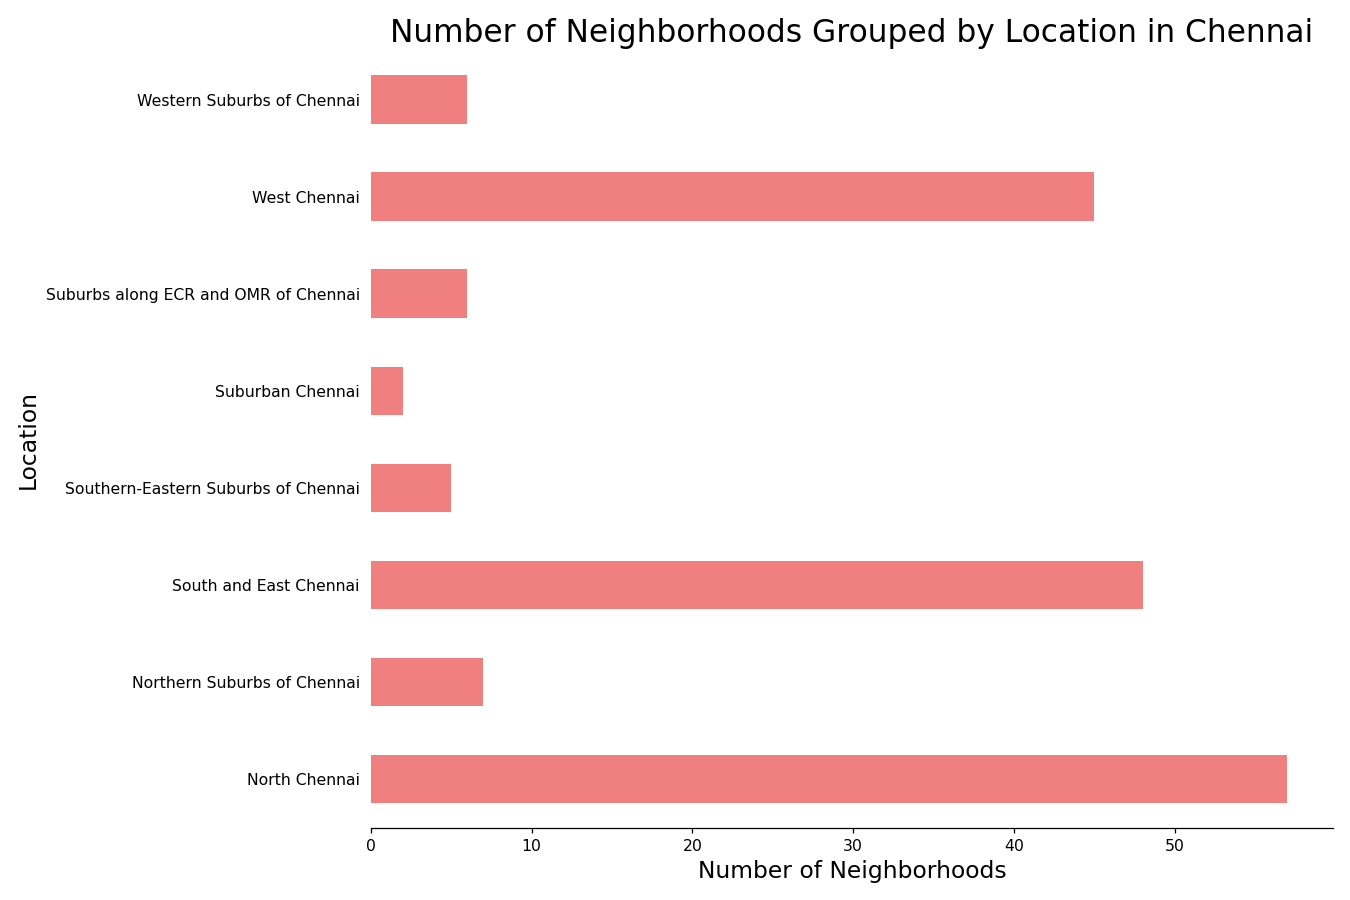

In [14]:
fig = plt.figure(figsize=(12,8))

ax = neighborhoods_chennai.plot(kind='barh', color='lightcoral')
ax.set_title('Number of Neighborhoods Grouped by Location in Chennai', fontsize=20)
ax.set_xlabel('Number of Neighborhoods', fontsize=15)
ax.set_ylabel('Location', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(which='major', left=False)

fig.tight_layout()

Clearly we can see that<b> North chennai and south and east chennai  have the most number of neighborhoods</b>. Notice how we see one of the locations as chennai itself? This is because the neighborhoods contained in this location are located at the outskirts of chennai and thus have been grouped as just chennai.

Now lets visualize the neighborhoods on a map using Folium. First we will obtain the geographical coordinates of chennai using GeoPy.

In [15]:
from geopy.geocoders import Nominatim

In [31]:
address = 'Chennai, IN'
geolocator = Nominatim(user_agent="coursera-capstone-project1")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Chennai are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Chennai are 13.0836939, 80.270186.


Now we can plot the map.

In [32]:

map_chennai = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, location, neighborhood in zip(df['Latitude'], df['Longitude'], df['Location'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chennai)  
    
map_chennai

### Using Foursquare API

Now we can start working with the Foursquare API to obtain venue recommendations.

Lets create the Foursquare credentials first.

In [18]:
# The code was removed by Watson Studio for sharing.

Lets start by exploring just the first neighborhood in our dataframe using Foursquare API.

In [33]:
neighborhood_name = df.loc[0, 'Neighborhood']
neighborhood_lat = df.loc[0, 'Latitude']
neighborhood_long = df.loc[0, 'Longitude']

print("The neighborhood is {} and it's geographical coordinates are {} latitude and {} longitude".format(neighborhood_name,
                                                                                                        neighborhood_lat, neighborhood_long))

The neighborhood is Adambakkam and it's geographical coordinates are 12.99192000000005 latitude and 80.20603000000006 longitude


In [34]:
CLIENT_ID="5VBIHGGSLPVIIO3BFUQIL3BDFGBJ4222IFUTE5Y3FTP0YVCN"
CLIENT_SECRET="MGOYTOPWD1WNID1GMG1DZQWWZUNKPDGNJG3WLP00VRX1SSXE"
VERSION=20120609
LIMIT = 200
radius = 1000

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_lat, 
    neighborhood_long, 
    radius, 
    LIMIT)

We can now use the GET method to get our results.

In [35]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '60195c63f0a2d32563b55d99'},
 'response': {'headerLocation': 'Velachery',
  'headerFullLocation': 'Velachery, Chennai',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 9,
  'suggestedBounds': {'ne': {'lat': 13.000920009000058,
    'lng': 80.21524920008119},
   'sw': {'lat': 12.982919991000042, 'lng': 80.19681079991892}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 1,
       'items': [{'summary': 'Lots of people like this place',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5155ca10e4b0cc3dad2cf381',
       'name': 'Pizza Republic',
       'contact': {},
       'location': {'address': 'VIHAS Restaurant',
        'crossStreet': '195/5 Medavakkam Main Road, Adambakkam',
        'lat': 12.99098677891081,
        'lng': 80.19861315843515,
        'labeledLatLngs': [{'label': 'display',
          'lat': 12.9909867789108

We will now create a function get_category_type to extract the categories of venues.

In [36]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we can clean the JSON obtained using the GET method and store our results in a dataframe.

In [37]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

<ipython-input-37-dc733077f29a>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues)


,name,categories,lat,lng
0,Pizza Republic,Pizza Place,12.990987,80.198613
1,Sukkkubai Beef Biryani Shop,Indian Restaurant,12.998769,80.201381
2,St Thomas Mount Railway Station,Train Station,12.994987,80.200302
3,Loiee,Bakery,12.992197,80.199000
4,Venkateshwara Super Market,Department Store,12.986320,80.205168


We can check how many venues were returned by Foursquare.

In [39]:
print("{} venues were returned for {} by Foursquare".format(len(nearby_venues), neighborhood_name))

9 venues were returned for Adambakkam by Foursquare


### Generalizing Foursquare API

Now that we have seen how the API call works and how we can clean our data to get relevant information, we can generalize this procedure to get nearby venues for all neighborhoods by creating the function getNearbyVenues.

In [40]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

We can apply the function created to get nearby venues for all neighborhoods in Chennai. We will get 200 nearby venues within a 1km radius, same as before.

In [41]:
chennai_venues = getNearbyVenues(names=df['Neighborhood'], latitudes=df['Latitude'], longitudes=df['Longitude'], radius=radius)

Adambakkam
Adyar
Alandur
Alapakkam
Alwarthirunagar
Ambattur
Aminjikarai
Anna Nagar
Annanur
Arumbakkam
Ashok Nagar
Avadi
Ayappakkam
Basin Bridge
Besant Nagar
Broadway
Central
Chetpet
Choolai
MMDA Colony
Defence Colony
Egmore
Ennore
Erukanchery
George Town
Gerugambakkam
Gopalapuram
Guindy
Hastinapuram
ICF Colony
Injambakkam
Irumbuliyur
Iyyapanthangal
Jamalia
K.K. Nagar
Kadaperi
Kallikuppam
Karambakkam
Kathirvedu
Kathivakkam
Keelkattalai
Kodungaiyur
Kolappakkam
Kolathur
Korattur
Korukkupet
Kosapet
Kottivakkam
Kovilambakkam
Koyambedu
Kundrathur
Lakshmipuram
M.G.R. Garden
M.G.R. Nagar
M.K.B. Nagar
Madhavaram
Madhavaram Milk Colony
Madipakkam
Maduravoyal
Mambakkam
Manali
Manali New Town
manapakkam
Mangadu
Manjambakkam
Mannadi
Mathur MMDA
Medavakkam
Minjur
Mogappair
Moolakadai
Mowlivakkam
Mudichur
Mugalivakkam
Mylapore
Nagalkeni
Nandambakkam
Nanganallur
Naravarikuppam
Neelankarai
Nerkundrum
Nesapakkam
New Washermenpet
Nolambur
Old Washermenpet
Oragadam
Otteri
Padi
Palavakkam
Pallavaram
Pallik

Lets see what our dataframe looks like.

In [42]:
print(chennai_venues.shape)
chennai_venues.head(10)

(2010, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adambakkam,12.99192,80.20603,Pizza Republic,12.990987,80.198613,Pizza Place
1,Adambakkam,12.99192,80.20603,Sukkkubai Beef Biryani Shop,12.998769,80.201381,Indian Restaurant
2,Adambakkam,12.99192,80.20603,St Thomas Mount Railway Station,12.994987,80.200302,Train Station
3,Adambakkam,12.99192,80.20603,Loiee,12.992197,80.199000,Bakery
4,Adambakkam,12.99192,80.20603,Venkateshwara Super Market,12.986320,80.205168,Department Store
5,Adambakkam,12.99192,80.20603,Deepam Restaurant,12.985380,80.205281,Indian Restaurant
6,Adambakkam,12.99192,80.20603,Design Hotel Chennai by jüSTa,12.992068,80.214965,Hotel
7,Adambakkam,12.99192,80.20603,St. Thomas Mount Metro Station,12.994772,80.197556,Metro Station
8,Adambakkam,12.99192,80.20603,Heritage Fresh,13.000499,80.208087,Supermarket
9,Adyar,13.00304,80.25187,That Madras Place,13.005848,80.250726,Café


Lets see how many venues were returned for each neighborhood.

In [43]:
chennai_venues.groupby('Neighborhood', as_index=False).count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adambakkam,9,9,9,9,9,9
1,Adyar,63,63,63,63,63,63
2,Alandur,16,16,16,16,16,16
3,Alapakkam,8,8,8,8,8,8
4,Alwarthirunagar,13,13,13,13,13,13
...,...,...,...,...,...,...,...
156,Villivakkam,6,6,6,6,6,6
157,Virugambakkam,6,6,6,6,6,6
158,Vyasarpadi,4,4,4,4,4,4
159,West Mambalam,19,19,19,19,19,19


We can now check how many unique categories are there in our data.

In [44]:
print("There are {} unique categories".format(chennai_venues['Venue Category'].nunique()))

There are 192 unique categories


### Analyzing each neighborhood

We can start analyzing each neighborhood by One-hot Encoding to see which categories belong in which neighborhoods.

In [45]:
chennai_onehot = pd.get_dummies(chennai_venues[['Venue Category']], prefix="", prefix_sep="")
chennai_onehot.head()

,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Amphitheater,Andhra Restaurant,Arcade,Arts & Crafts Store,...,Train,Train Station,Travel & Transport,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Warehouse Store,Whisky Bar,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Adding Neighborhood column to the one-hot encoded dataframe.

In [46]:
chennai_onehot['Neighborhood'] = chennai_venues['Neighborhood']
chennai_onehot.head()

,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Amphitheater,Andhra Restaurant,Arcade,Arts & Crafts Store,...,Train,Train Station,Travel & Transport,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Warehouse Store,Whisky Bar,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Moving the Neighborhood column to the first column.

In [47]:
temp = list(chennai_onehot.columns)

if 'Neighborhood' in temp:
    temp.remove('Neighborhood')
    
fixed_columns = ['Neighborhood'] + temp
chennai_onehot = chennai_onehot[fixed_columns]

chennai_onehot.head()

,Neighborhood,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Amphitheater,Andhra Restaurant,Arcade,...,Train,Train Station,Travel & Transport,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Warehouse Store,Whisky Bar,Women's Store,Yoga Studio
0,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we can groupby neighborhood and take the mean for all categories.

In [102]:
chennai_grouped = chennai_onehot.groupby('Neighborhood', sort=False).mean().reset_index()
print(chennai_grouped .shape)
chennai_grouped .head(10)

(161, 192)


,Neighborhood,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Amphitheater,Andhra Restaurant,Arcade,...,Train,Train Station,Travel & Transport,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Warehouse Store,Whisky Bar,Women's Store,Yoga Studio
0,Adambakkam,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.111111,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
1,Adyar,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.015873,...,0.0,0.000000,0.0,0.015873,0.0,0.0,0.0,0.0,0.015873,0.0
2,Alandur,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.062500,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
3,Alapakkam,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
4,Alwarthirunagar,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
5,Ambattur,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
6,Aminjikarai,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
7,Anna Nagar,0.0,0.0,0.0,0.0,0.0,0.014706,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.044118,0.0,0.0,0.0,0.0,0.000000,0.0
8,Annanur,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.333333,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
9,Arumbakkam,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.133333,0.0,0.0,0.0,0.0,0.000000,0.0


In order to further understand the data, we can display the top 5 venues of all neighborhoods.

In [103]:
num_top_venues = 5

for hood in chennai_grouped ['Neighborhood']:
    print("----"+hood+"----")
    temp = chennai_grouped [chennai_grouped ['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adambakkam----
               venue  freq
0  Indian Restaurant  0.22
1   Department Store  0.11
2      Train Station  0.11
3        Supermarket  0.11
4              Hotel  0.11


----Adyar----
                  venue  freq
0     Indian Restaurant  0.25
1                  Café  0.06
2      Asian Restaurant  0.05
3          Dessert Shop  0.05
4  Fast Food Restaurant  0.05


----Alandur----
               venue  freq
0  Indian Restaurant  0.19
1             Bakery  0.12
2              Hotel  0.12
3      Metro Station  0.12
4      Train Station  0.06


----Alapakkam----
                  venue  freq
0      Department Store  0.25
1  Fast Food Restaurant  0.25
2        Sandwich Place  0.12
3      Asian Restaurant  0.12
4        Clothing Store  0.12


----Alwarthirunagar----
                  venue  freq
0        Clothing Store  0.15
1  Fast Food Restaurant  0.15
2             Multiplex  0.08
3                  Café  0.08
4        Ice Cream Shop  0.08


----Ambattur----
              venu

Lets now create a dataframe with the top 10 common venues for each neighborhood.

In [104]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [105]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = chennai_grouped['Neighborhood']

for ind in np.arange(chennai_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chennai_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adambakkam,Indian Restaurant,Train Station,Metro Station,Supermarket,Hotel,Bakery,Pizza Place,Department Store,Fried Chicken Joint,Food Truck
1,Adyar,Indian Restaurant,Café,Fast Food Restaurant,Dessert Shop,Pizza Place,Asian Restaurant,Electronics Store,North Indian Restaurant,Ice Cream Shop,Chinese Restaurant
2,Alandur,Indian Restaurant,Metro Station,Hotel,Bakery,Supermarket,Breakfast Spot,Church,Café,Pizza Place,Train Station
3,Alapakkam,Department Store,Fast Food Restaurant,Clothing Store,Asian Restaurant,Sandwich Place,Chettinad Restaurant,Flower Shop,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint
4,Alwarthirunagar,Clothing Store,Fast Food Restaurant,Chinese Restaurant,Movie Theater,Smoke Shop,Gym,Café,Multiplex,Ice Cream Shop,Pizza Place
...,...,...,...,...,...,...,...,...,...,...,...
156,Kanathur,Movie Theater,Café,Whisky Bar,Juice Bar,Food,Garden,Gaming Cafe,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint
157,Muthukadu,Indian Restaurant,Museum,Coffee Shop,Hotel,Theme Park,Flea Market,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck
158,Kelambakkam,Indian Restaurant,Bus Station,Coffee Shop,Fast Food Restaurant,Café,Yoga Studio,Food,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint
159,Kovalam,Indian Restaurant,Seafood Restaurant,Café,Hotel,Resort,Restaurant,Surf Spot,Beach,Bar,Yoga Studio


### Clustering neighborhoods

Now we can use KMeans clustering method to cluster the neighborhoods.

First we need to determine how many clusters to use. This will be done using the Silhouette Score.

We will define a function to plot the Silhouette Score that will be calculated using different number of clusters. 

In [106]:
def plot(x, y):
    fig = plt.figure(figsize=(12,6))
    plt.plot(x, y, 'o-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Scores')
    plt.title('Checking Optimum Number of Clusters')
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

In [107]:
maxk = 15
scores = []
kval = []

for k in range(2, maxk+1):
    cl_df = chennai_grouped.drop('Neighborhood', axis=1)
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=40).fit_predict(cl_df) #Choose any random_state
    
    score = silhouette_score(cl_df, kmeans, metric='euclidean', random_state=0)
    kval.append(k)
    scores.append(score)

We can now display the scores for different number of clusters and plot the data as well.

[0.13001415490019286, 0.14058080150465582, 0.16359747557782178, 0.1514060516447099, 0.10293949987835495, 0.1061768009851362, 0.13134315743102876, 0.13501755090303574, 0.08149884936456084, 0.08400559469203524, 0.12861737560910522, 0.126538775100004, 0.10055036873688378, 0.0997970568627141]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


<IPython.core.display.Javascript object>


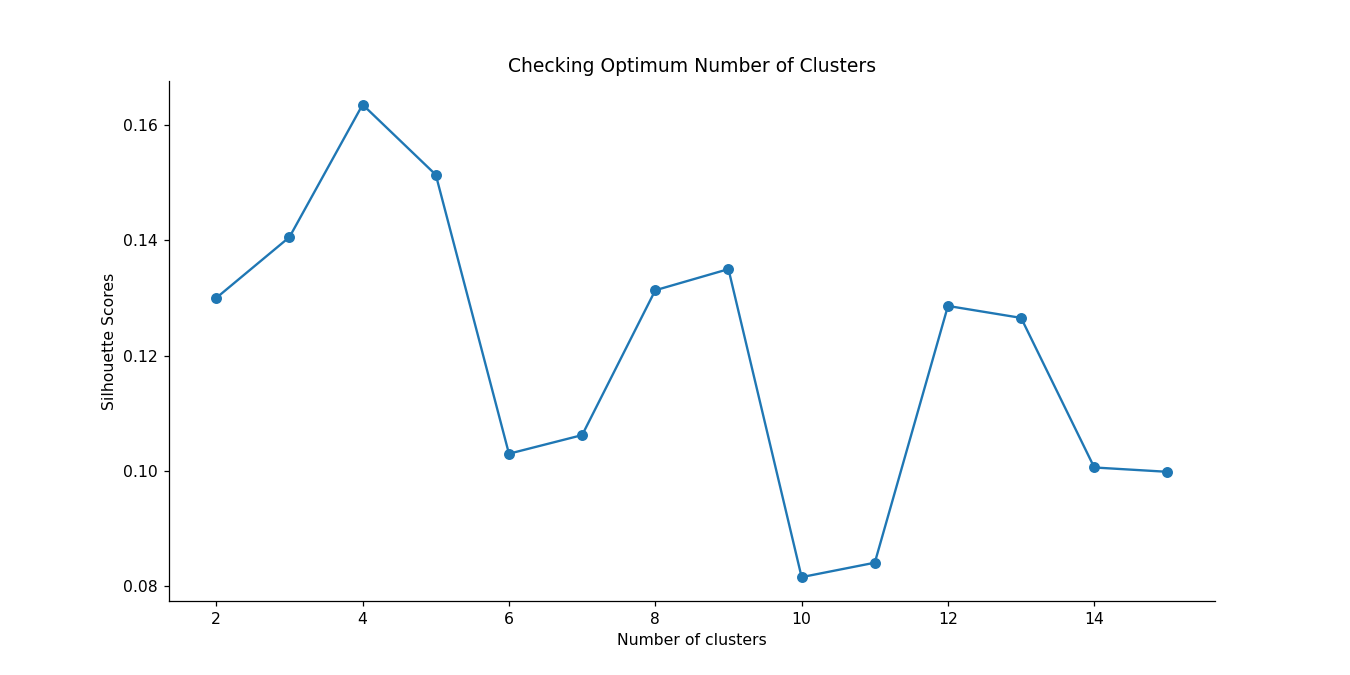

In [108]:
print(scores)
print(kval)
plot(kval, scores)

We can see that the silhouette scores are not very high even as we increase the number of clusters. This means that the inter-cluster distance between different clusters is not very high over the range of k-values. However, we will try to cluster our data as best as we can. For this, we will use 5 clusters for our clustering model since it provides the highest silhouette score as seen above.

In [109]:
k = 4

chennai_clustering = chennai_grouped.drop('Neighborhood', axis=1)
kmeans = KMeans(n_clusters=k, init="k-means++", random_state=40).fit(chennai_clustering) #Can choose any random_state

type(kmeans.labels_)

numpy.ndarray

Now we can create a new dataframe that includes cluster labels and the top 10 venues.

In [110]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
chennai_merged = df
chennai_merged = chennai_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Lets view the newly created dataframe.

In [111]:
print(chennai_merged.shape)
chennai_merged

(176, 15)


,Neighborhood,Location,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adambakkam,South and East Chennai,12.9919,80.206,2.0,Indian Restaurant,Train Station,Metro Station,Supermarket,Hotel,Bakery,Pizza Place,Department Store,Fried Chicken Joint,Food Truck
1,Adyar,South and East Chennai,13.003,80.2519,2.0,Indian Restaurant,Café,Fast Food Restaurant,Dessert Shop,Pizza Place,Asian Restaurant,Electronics Store,North Indian Restaurant,Ice Cream Shop,Chinese Restaurant
2,Alandur,South and East Chennai,13.0001,80.2006,2.0,Indian Restaurant,Metro Station,Hotel,Bakery,Supermarket,Breakfast Spot,Church,Café,Pizza Place,Train Station
3,Alapakkam,West Chennai,13.0461,80.165,2.0,Department Store,Fast Food Restaurant,Clothing Store,Asian Restaurant,Sandwich Place,Chettinad Restaurant,Flower Shop,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint
4,Alwarthirunagar,West Chennai,13.0506,80.184,2.0,Clothing Store,Fast Food Restaurant,Chinese Restaurant,Movie Theater,Smoke Shop,Gym,Café,Multiplex,Ice Cream Shop,Pizza Place
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,Kanathur,Suburbs along ECR and OMR of Chennai,12.8472,80.2414,2.0,Movie Theater,Café,Whisky Bar,Juice Bar,Food,Garden,Gaming Cafe,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint
172,Muthukadu,Suburbs along ECR and OMR of Chennai,12.8317,80.2421,0.0,Indian Restaurant,Museum,Coffee Shop,Hotel,Theme Park,Flea Market,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck
173,Kelambakkam,Suburbs along ECR and OMR of Chennai,12.7861,80.2203,2.0,Indian Restaurant,Bus Station,Coffee Shop,Fast Food Restaurant,Café,Yoga Studio,Food,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint
174,Kovalam,Suburbs along ECR and OMR of Chennai,12.7898,80.2491,2.0,Indian Restaurant,Seafood Restaurant,Café,Hotel,Resort,Restaurant,Surf Spot,Beach,Bar,Yoga Studio


In [112]:
type(chennai_merged)

pandas.core.frame.DataFrame

In [113]:
chennai_merged.describe()

,Cluster Labels
count,167.000000
mean,1.772455
std,0.664746
min,0.000000
25%,2.000000
50%,2.000000
75%,2.000000
max,3.000000


We can visualize the clustering by creating a map.

marking with 4 which does not have any recomendation

In [124]:
chennai_merged['Cluster Labels'] = chennai_merged['Cluster Labels'].replace(np.nan, 4)

In [116]:
chennai_merged['Cluster Labels'].unique()

array([2., 3., 0., 4., 1.])

In [117]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(chennai_merged['Latitude'], chennai_merged['Longitude'], chennai_merged['Neighborhood'], chennai_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=rainbow[int(cluster-1.00)],
        fill=True,
        fill_color=rainbow[int(cluster-1.00)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

We can now view the neighborhoods in each cluster and their top 10 most common venues.

### Cluster 1

In [118]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 0, chennai_merged.columns[[0] + [1] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,Location,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Broadway,North Chennai,0.0,Indian Restaurant,Video Store,Restaurant,Market,Harbor / Marina,Yoga Studio,Flea Market,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck
35,Kadaperi,South and East Chennai,0.0,Indian Restaurant,Jewelry Store,Light Rail Station,Train Station,Flea Market,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck,Food Service
46,Kosapet,North Chennai,0.0,Indian Restaurant,Department Store,Hotel,Yoga Studio,Flower Shop,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck,Food Service
57,Madipakkam,South and East Chennai,0.0,Indian Restaurant,Department Store,Convenience Store,Yoga Studio,Flower Shop,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck,Food Service
62,manapakkam,West Chennai,0.0,Indian Restaurant,Trail,Yoga Studio,Flower Shop,Gaming Cafe,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck,Food Service
64,Manjambakkam,North Chennai,0.0,Indian Restaurant,Yoga Studio,Flower Shop,Gaming Cafe,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck,Food Service,Food Court
67,Medavakkam,South and East Chennai,0.0,Indian Restaurant,Vegetarian / Vegan Restaurant,Chinese Restaurant,Pizza Place,Convenience Store,Bakery,Flea Market,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck
93,Parry's Corner,North Chennai,0.0,Indian Restaurant,Video Store,Market,Harbor / Marina,Yoga Studio,Flower Shop,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck
120,Sowcarpet,North Chennai,0.0,Indian Restaurant,Men's Store,Video Store,Restaurant,Market,Harbor / Marina,Outlet Store,Yoga Studio,Fried Chicken Joint,Food Truck
150,Kancheepuram,Suburban Chennai,0.0,Indian Restaurant,Yoga Studio,Flower Shop,Gaming Cafe,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck,Food Service,Food Court


### Cluster 2

In [119]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 1, chennai_merged.columns[[0] + [1] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,Location,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
38,Kathirvedu,North Chennai,1.0,ATM,Snack Place,Food & Drink Shop,Cricket Ground,Gaming Cafe,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck,Food Service
41,Kodungaiyur,North Chennai,1.0,ATM,Pharmacy,Coffee Shop,Bank,Food,Gaming Cafe,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck
43,Kolathur,North Chennai,1.0,ATM,Indian Restaurant,Bus Stop,Flower Shop,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck,Food Service,Food Court
44,Korattur,West Chennai,1.0,ATM,Flower Shop,Gaming Cafe,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck,Food Service,Food Court,Food & Drink Shop
48,Kovilambakkam,South and East Chennai,1.0,ATM,Indian Restaurant,Bar,Flower Shop,Gaming Cafe,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck,Food Service
50,Kundrathur,West Chennai,1.0,ATM,Soup Place,Bus Station,Garden,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck,Food Service,Food Court
51,Lakshmipuram,North Chennai,1.0,ATM,Department Store,Intersection,Indian Restaurant,Photography Studio,Hotel,Flea Market,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck
63,Mangadu,West Chennai,1.0,ATM,Pharmacy,Fast Food Restaurant,Flower Shop,Gaming Cafe,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck,Food Service
70,Moolakadai,North Chennai,1.0,ATM,Coffee Shop,Gym,Bakery,Currency Exchange,Electronics Store,Donut Shop,Gaming Cafe,Dessert Shop,Furniture / Home Store
72,Mudichur,South and East Chennai,1.0,Breakfast Spot,Pharmacy,Yoga Studio,Food,Gaming Cafe,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck,Food Service


### Cluster 3

In [120]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 2, chennai_merged.columns[[0] + [1] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,Location,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adambakkam,South and East Chennai,2.0,Indian Restaurant,Train Station,Metro Station,Supermarket,Hotel,Bakery,Pizza Place,Department Store,Fried Chicken Joint,Food Truck
1,Adyar,South and East Chennai,2.0,Indian Restaurant,Café,Fast Food Restaurant,Dessert Shop,Pizza Place,Asian Restaurant,Electronics Store,North Indian Restaurant,Ice Cream Shop,Chinese Restaurant
2,Alandur,South and East Chennai,2.0,Indian Restaurant,Metro Station,Hotel,Bakery,Supermarket,Breakfast Spot,Church,Café,Pizza Place,Train Station
3,Alapakkam,West Chennai,2.0,Department Store,Fast Food Restaurant,Clothing Store,Asian Restaurant,Sandwich Place,Chettinad Restaurant,Flower Shop,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint
4,Alwarthirunagar,West Chennai,2.0,Clothing Store,Fast Food Restaurant,Chinese Restaurant,Movie Theater,Smoke Shop,Gym,Café,Multiplex,Ice Cream Shop,Pizza Place
...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,Urapakkam,Southern-Eastern Suburbs of Chennai,2.0,South Indian Restaurant,Juice Bar,Department Store,Indian Restaurant,Coffee Shop,Flower Shop,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck
169,Guduvanchery,Southern-Eastern Suburbs of Chennai,2.0,Department Store,Indie Movie Theater,Indian Restaurant,North Indian Restaurant,Bakery,Food,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck
171,Kanathur,Suburbs along ECR and OMR of Chennai,2.0,Movie Theater,Café,Whisky Bar,Juice Bar,Food,Garden,Gaming Cafe,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint
173,Kelambakkam,Suburbs along ECR and OMR of Chennai,2.0,Indian Restaurant,Bus Station,Coffee Shop,Fast Food Restaurant,Café,Yoga Studio,Food,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint


### Cluster 4

In [121]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 3, chennai_merged.columns[[0] + [1] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,Location,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Annanur,West Chennai,3.0,Platform,Train Station,Medical Supply Store,Stationery Store,Flea Market,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck,Food Service
22,Ennore,North Chennai,3.0,Train Station,Yoga Studio,Flower Shop,Gaming Cafe,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck,Food Service,Food Court
68,Minjur,North Chennai,3.0,Train Station,Scenic Lookout,Park,Yoga Studio,Flea Market,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck,Food Service
131,Thirunindravur,West Chennai,3.0,Train Station,Pharmacy,Yoga Studio,Flea Market,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck,Food Service,Food Court
154,Athipattu,Northern Suburbs of Chennai,3.0,Train Station,Platform,Yoga Studio,Flea Market,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck,Food Service,Food Court
156,Minjur,Northern Suburbs of Chennai,3.0,Train Station,Scenic Lookout,Park,Yoga Studio,Flea Market,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck,Food Service
158,Ennore,Northern Suburbs of Chennai,3.0,Train Station,Yoga Studio,Flower Shop,Gaming Cafe,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck,Food Service,Food Court
161,Thirunindravur,Western Suburbs of Chennai,3.0,Train Station,Pharmacy,Yoga Studio,Flea Market,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck,Food Service,Food Court


## Results and Discussion

By analyzing the five clusters obtained we can see that some of the clusters are more suited for restaurants and hotels, whereas, other clusters are less suited. Neighborhoods in clusters 3, 4 contain a small percentage of restaurants, hotels, cafe and pubs in their top 10 common venues. These clusters contain a higher degree of other venues like train station, bus station, fish market, gym, performing arts venue and smoke shop, to name a few. Thus, they are not well suited for opening a new restaurant. On the other hand, neighborhoods in clusters 1 and 2 contain a much higher degree of restaurants, hotels, multiplex, cafes, bars and other food joints. Thus, the neighborhoods in these clusters would be well suited for opening a new restaurant.

Comparing clusters 1 and 2, neighborhoods in cluster 1 seem to be more suited for starting a restaurant since they contains a larger percentage of food joints in the top 10 most common venues than cluster 2. The neighborhoods in cluster 1 contain a variety of food joints like restaurants, tea rooms, bakery, cafe, steakhouse and pubs and also contain very diverse cuisines like Japanese, Indian, Chinese, Italian and seafood restaurants. Most neighborhoods in cluster 2 seem to have Indian Restaurant as their top most common venue; however, on careful analysis we can see that neighborhoods in cluster 2 also contain other venues like soccer field, flea market, smoke shop, gym, train station, dance studio, music store, cosmetics shop and so on. Thus, it is recommended that the new restaurant can be opened in the neighborhoods belonging to cluster 1. This neighborhood can be further plotted on a map as shown below.

In [122]:
new_restaurant_neighborhoods = chennai_merged.loc[chennai_merged['Cluster Labels'] == 0, chennai_merged.columns[[0, 1, 2, 3] + list(range(4, chennai_merged.shape[1]))]]
new_restaurant_neighborhoods

,Neighborhood,Location,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Broadway,North Chennai,13.0942,80.2854,0.0,Indian Restaurant,Video Store,Restaurant,Market,Harbor / Marina,Yoga Studio,Flea Market,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck
35,Kadaperi,South and East Chennai,12.9336,80.1243,0.0,Indian Restaurant,Jewelry Store,Light Rail Station,Train Station,Flea Market,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck,Food Service
46,Kosapet,North Chennai,13.0945,80.2551,0.0,Indian Restaurant,Department Store,Hotel,Yoga Studio,Flower Shop,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck,Food Service
57,Madipakkam,South and East Chennai,12.9647,80.2087,0.0,Indian Restaurant,Department Store,Convenience Store,Yoga Studio,Flower Shop,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck,Food Service
62,manapakkam,West Chennai,13.0119,80.1716,0.0,Indian Restaurant,Trail,Yoga Studio,Flower Shop,Gaming Cafe,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck,Food Service
64,Manjambakkam,North Chennai,13.1656,80.2294,0.0,Indian Restaurant,Yoga Studio,Flower Shop,Gaming Cafe,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck,Food Service,Food Court
67,Medavakkam,South and East Chennai,12.9201,80.1923,0.0,Indian Restaurant,Vegetarian / Vegan Restaurant,Chinese Restaurant,Pizza Place,Convenience Store,Bakery,Flea Market,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck
93,Parry's Corner,North Chennai,13.0896,80.2904,0.0,Indian Restaurant,Video Store,Market,Harbor / Marina,Yoga Studio,Flower Shop,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck
120,Sowcarpet,North Chennai,13.091,80.2834,0.0,Indian Restaurant,Men's Store,Video Store,Restaurant,Market,Harbor / Marina,Outlet Store,Yoga Studio,Fried Chicken Joint,Food Truck
150,Kancheepuram,Suburban Chennai,12.8952,80.1376,0.0,Indian Restaurant,Yoga Studio,Flower Shop,Gaming Cafe,Furniture / Home Store,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck,Food Service,Food Court


In [125]:
map_res_locations = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, location, neighborhood in zip(new_restaurant_neighborhoods['Latitude'], new_restaurant_neighborhoods['Longitude'],
                                            new_restaurant_neighborhoods['Location'], new_restaurant_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, location)
    folium.Marker([lat, lng], popup='{} has geographical coordinates ({:.4f}, {:.4f})'.format(label, lat, lng),
                  icon=folium.Icon(color='lightred'), tooltip=label).add_to(map_res_locations)
    
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_res_locations) 

map_res_locations

## Conclusion

We have successfully analyzed the neighborhoods in  Chennai , India for determining which would be the best neighborhoods for opening a new restaurant. Based on our analysis, neighborhoods in cluster 1 are recommended as locations for the new restaurant. This has also been plotted in the map above. The stakeholders and investors can further tune this by considering various other factors like transport, legal requirements, and costs associated. These were out of the scope for this project and thus were not considered.

## Final Understanding:



In [132]:
new_restaurant_neighborhoods[['Neighborhood', 'Location','1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue']]

,Neighborhood,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
15,Broadway,North Chennai,Indian Restaurant,Video Store,Restaurant
35,Kadaperi,South and East Chennai,Indian Restaurant,Jewelry Store,Light Rail Station
46,Kosapet,North Chennai,Indian Restaurant,Department Store,Hotel
57,Madipakkam,South and East Chennai,Indian Restaurant,Department Store,Convenience Store
62,manapakkam,West Chennai,Indian Restaurant,Trail,Yoga Studio
64,Manjambakkam,North Chennai,Indian Restaurant,Yoga Studio,Flower Shop
67,Medavakkam,South and East Chennai,Indian Restaurant,Vegetarian / Vegan Restaurant,Chinese Restaurant
93,Parry's Corner,North Chennai,Indian Restaurant,Video Store,Market
120,Sowcarpet,North Chennai,Indian Restaurant,Men's Store,Video Store
150,Kancheepuram,Suburban Chennai,Indian Restaurant,Yoga Studio,Flower Shop



# Broadway ,Kadaperi ,Kosapet  ,Madipakkam ,manapakkam, Manjambakkam, Medavakkam ,Parry's Corner ,Sowcarpet ,Kancheepuram ,Chengalpattu ,Tiruvallur ,Karapakkam ,Muthukadu


# Above all these places first choice of shop is Indian Restaurant .	 


# Thank You!